# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


matplotlib settings set
matplotlib settings set


In [3]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df




def xray_filtration(df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,
                    verbouse=True) -> pd.DataFrame:
    """
    Filters X-ray sources.
    TODO: remake processing of duplicates
    """
    
    if verbouse:
        print(f'DET_LIKE_0 > {DL_thresh}')
        print(f'EXT_LIKE < {EL_thresh}')
        print()

        print(f'Before X-ray source filters: {len(df)}')

    df = df[(df['DET_LIKE_0'] > DL_thresh)&
            (df['EXT_LIKE'] < EL_thresh)]

    if verbouse:
        print(f'After X-ray source filters: {len(df)}')
        print()


    # Manually get rid of faint sources in duplicated pairs
    df = df[~((df['srcname_fin']=='SRGe J104659.3+573056')&(df['DET_LIKE_0'] < 20))]
    df = df[~((df['srcname_fin'] == 'SRGe J104700.7+574558')&(df['DET_LIKE_0'] < 20))]
    print('Weak ERO duplicates removed (temporary measure)')
    print()

    return df



srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [4]:
# Каталог ERO (9500)
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df = xray_filtration(ero_df, DL_thresh=6, EL_thresh=6)
ero_df.sample(5)

DET_LIKE_0 > 6
EXT_LIKE < 6

Before X-ray source filters: 9500
After X-ray source filters: 9228

Weak ERO duplicates removed (temporary measure)



,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
6265,SRGe J104252.8+571821,160.719964,57.305718,150.932330,52.260595,8.998160,10.692753,5.712322e-15,1.647984e-15,27.132944,7.827754,4339.420410,0.0,0.0,0.0,7682,6551,160.721972,57.304429,3.935030,193.606735,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.006253,0.001804,20.027241,160.719964,57.305718,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1237655107835462236,0,1.626765,65325904165,3.935030,3.216903,4.856212,7.874165,135.651915,44.521450,4.395855e-15,5.626205e+19
8040,SRGe J104503.6+585109,161.265071,58.852523,148.722645,51.476794,11.446650,8.665966,4.138108e-15,1.380834e-15,19.472338,6.497673,4298.963867,0.0,0.0,0.0,8504,7356,161.267079,58.851233,5.050855,134.198166,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.004530,0.001511,17.837753,161.265071,58.852523,-1,-1.0,0,-1,NaN,-1.0,-1,CLANS 282,1.02,Galaxy,6.785064,1,1,1,1,16.340000,15.043,12.697,17.4,14.0,2.2,1,1,1,1237655109446468339,0,7.053267,59440036163,5.050855,4.092255,6.177636,10.016804,134.823856,45.982918,3.184435e-15,7.752116e+19
2977,SRGe J104225.4+554312,160.605637,55.719997,153.048147,53.197115,5.282430,61.051086,1.217269e-14,1.967107e-15,57.582363,9.305311,4321.657715,0.0,0.0,0.0,2672,2131,160.607645,55.718708,2.203658,115.242424,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.013324,0.002153,17.941013,160.605637,55.719997,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,16.674999,15.996,12.639,14.1,7.5,0.3,1,1,1,1237657771786699524,0,5.027307,71622000508,2.203658,1.888505,2.850872,4.622581,136.721087,43.134488,9.367361e-15,5.906809e+19
9381,SRGe J103218.2+554845,158.075810,55.812564,154.302084,51.991382,12.056311,6.247810,2.780278e-15,1.001216e-15,17.837025,6.423356,5861.133301,0.0,0.0,0.0,7898,6758,158.077819,55.811275,5.327397,54.344074,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.003043,0.001096,43.520290,158.075810,55.812564,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,2,17.278000,16.681,12.736,8.5,4.1,-2.0,2,0,-1,0,0,NaN,71246284184,5.327397,4.310213,6.506664,10.550310,134.985250,42.492209,2.139533e-15,6.954021e+19
5255,SRGe J105107.1+585732,162.779450,58.958800,147.742211,51.980972,5.999183,23.160820,6.894000e-15,1.582173e-15,32.146908,7.377714,4260.057129,0.0,0.0,0.0,5205,4248,162.781459,58.957511,2.544748,143.203308,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.007546,0.001732,18.055658,162.779450,58.958800,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,16.313999,15.648,12.722,17.0,10.0,-1.2,1,2,0,1237655109446795516,0,2.446566,59045566491,2.544748,2.144749,3.237696,5.249802,135.686392,46.499724,5.305202e-15,8.712954e+19


In [5]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
513475,9011,403,615251,157.190136,59.241091,44.223667,112.446890,174.379970,78.400475,40.338660,-7.348948,-144.43303,110.45843,38.50083,26.587925,2.332695,0.857827,0.001215,0.000015,18.365871,17.359165,16.888725,17.763060,18.484993,NaN,NaN,464.787230,697.722170,899.163800,119.742330,37.361237,-0.256179,-0.554339,PSF,1.153903,51.421276,-8.349268,63.04476,-8.340671,35.849644,G2,1047332761587627648,58226.252885,57820.342431,2018-04-18 06:04:09.258,2017-03-08 08:13:06,9011_615251_403
951392,9011,2700,610725,163.070112,57.709849,0.095102,0.203244,1.751082,8.525819,6.926920,-9.695474,-132.87584,428.94470,120.70098,90.926950,4.235994,1.071148,0.001590,0.000020,25.026106,24.210810,21.881023,20.171532,20.397650,NaN,NaN,1.969646,2.232917,16.697548,17.547440,7.169104,-0.386590,-0.588222,REX,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0,58194.404310,57519.167060,2018-03-17 09:42:12.399,2016-05-11 04:00:34,9011_610725_2700
247028,9011,3590,617461,164.040559,60.046110,0.750676,1.164601,2.195020,7.614471,11.813666,10.498329,999.75020,726.91120,219.67303,106.625595,4.549904,1.154358,0.001562,0.000019,22.782734,22.315268,21.635614,20.294262,19.818031,19.946985,15.000190,20.239204,17.260988,22.665700,16.242050,12.692728,0.414896,4.411155,PSF,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0,58194.477145,57492.230509,2018-03-17 11:27:05.369,2016-04-14 05:31:56,9011_617461_3590
208505,9011,2166,618180,162.731446,60.258519,0.423530,0.373475,0.316856,-0.674697,-1.714961,-1.245392,816.06525,343.64490,109.65709,64.189670,4.467541,1.157940,0.001223,0.000016,23.410734,23.554490,23.739534,NaN,NaN,NaN,15.220625,7.851261,3.910929,2.538602,-1.426076,-1.845429,-0.043558,3.231191,REX,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0,58226.277514,57414.424398,2018-04-18 06:39:37.240,2016-01-27 10:11:08,9011_618180_2166
2149862,9011,3384,608371,157.095471,57.089200,0.290369,0.216366,0.973453,1.548800,4.825060,59.249264,-344.06198,335.80023,176.69922,119.446140,4.169608,1.039419,0.001527,0.000018,23.819016,24.146126,22.520317,22.023659,20.790413,18.068115,NaN,5.320968,2.876109,10.639004,3.162591,4.919240,2.315012,-1.456798,PSF,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0,57916.197535,57824.398484,2017-06-12 04:44:27.000,2017-03-12 09:33:49,9011_608371_3384


# CSC

In [6]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
15586,2CXO J010258.6-213445,15.744414,-21.579356,0.963858,0.838848,179.310506,2.702703,38.859894,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,7.211044e-17,2.090657e-16,1.115017e-16,3.066297e-16,2.090657e-16,0.522017,1.460161,2.090657e-16,1.556836e-16
138059,2CXO J112835.1+565933,172.146311,56.992595,3.151287,3.151287,0.000000,4.777778,52.428521,TRUE,False,False,False,False,False,False,False,8.592911e-16,2.666766e-16,1.451906e-15,1.622894e-15,1.182787e-15,2.063001e-15,2.482185e-15,1.820692,5.092748,2.482185e-15,1.043922e-15
241597,2CXO J174502.1-293948,266.258848,-29.663338,2.178819,1.669786,166.038472,3.352941,26.545196,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.121470,3.136920,NaN,NaN
214412,2CXO J161801.7+070450,244.507143,7.080669,0.712994,0.712768,55.687781,11.446618,1076.707754,TRUE,False,False,False,False,False,False,False,3.394745e-14,2.901993e-14,3.854647e-14,3.529795e-14,2.995451e-14,4.032706e-14,6.924539e-14,0.411875,1.152076,6.924539e-14,9.963718e-15
299781,2CXO J215842.9-011459,329.678755,-1.249917,0.838769,0.831240,35.339563,3.411765,84.850370,TRUE,False,False,False,False,False,False,False,5.025757e-15,2.512878e-15,7.406378e-15,7.562694e-15,4.159482e-15,1.077684e-14,1.258845e-14,0.482438,1.349452,1.258845e-14,5.821898e-15


In [7]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')


## CSC x ERO cross-match

In [8]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])
ero_csc['csc_ero_flux_ratio'] = ero_csc['csc_flux_csc_05_2'] / ero_csc['flux_05-20']

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 742 out of 9226 x 267265
	 total unique pairs: 689
	 total non-unique pairs (duplicates in df2): 53
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 563


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,csc_ero_flux_ratio
219,SRGe J104719.1+593647,161.829470,59.613062,147.510978,51.179218,4.882438,51.944511,1.338737e-14,2.362273e-15,63.485649,11.202379,4332.392090,0.0,0.0,0.0,3345,2665,161.831479,59.611773,2.010405,100.088364,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.014654,0.002586,24.554764,161.829470,59.613062,-1,-1.000000,0,-1,NaN,-1.0,-1,CXOSW J104719.9+593651,NaN,X,9.574251,1,1,0,2,17.410000,17.249001,12.459,6.8,2.2,0.5,2,1,1,1237653616934454328,0,7.641121,56640321615,2.010405,1.745505,2.635000,4.272554,134.571177,46.777514,1.030210e-14,8.331537e+19,2CXO J104719.8+593652,161.832831,59.614497,5.939428,2.879905,83.290585,7.738814,121.673301,TRUE,False,False,False,False,False,False,False,7.939924e-15,5.703326e-15,1.006469e-14,7.771946e-15,6.335825e-15,9.208066e-15,1.571187e-14,2.696687,7.543038,1.571187e-14,3.693494e-15,8.006849,1,1,1.525113
51,SRGe J105401.1+574558,163.504569,57.766040,148.733667,53.078049,3.047873,306.146393,4.160429e-14,3.450577e-15,195.728119,16.233299,4297.961914,0.0,0.0,0.0,300,254,163.506577,57.764750,1.061916,45.685696,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.045540,0.003777,17.483870,163.504569,57.766040,860210725948107776,5.488451,1,0,20.901157,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,16.027000,15.653000,12.199,22.5,10.4,1.4,1,1,0,1237655107836182782,0,5.601493,63547518337,1.061916,1.089635,1.644905,2.667151,137.089504,45.711681,3.201613e-14,6.671395e+19,2CXO J105401.1+574556,163.504758,57.765833,1.330923,1.022761,88.965280,5.085714,149.925569,TRUE,False,False,False,False,False,False,True,1.405153e-14,9.279314e-15,1.855863e-14,1.620899e-14,1.119894e-14,2.121904e-14,3.026052e-14,0.685737,1.918109,3.026052e-14,9.658633e-15,0.827519,1,1,0.945165
414,SRGe J110602.0+585809,166.508150,58.969280,145.447384,53.306381,9.214740,9.668420,7.003751e-15,2.557649e-15,11.817037,4.315378,1541.435669,0.0,0.0,0.0,8792,7639,166.510158,58.967990,4.034172,82.604370,0.000012,6.268413e+08,6.270701e+08,0.0,0.0,0.007666,0.002800,7.899126,166.508150,58.969280,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,17.816999,17.096001,12.371,5.1,0.6,0.6,1,0,-1,0,0,NaN,59006404700,4.034172,3.294332,4.973098,8.063690,138.009490,47.590353,5.389659e-15,6.694294e+19,2CXO J110601.5+585807,166.506544,58.968797,0.801565,0.784976,21.998943,3.588235,169.986658,TRUE,False,False,False,False,False,False,False,3.599574e-16,8.638978e-17,6.335251e-16,1.220502e-15,6.571933e-16,1.752516e-15,1.580459e-15,0.458346,1.282062,1.580459e-15,8.660448e-16,3.449818,1,1,0.293239
193,SRGe J105657.7+573236,164.240527,57.543244,148.546575,53.516425,5.083640,65.438942,1.476259e-14,2.355627e-15,58.313759,9.304972,3608.743896,0.0,0.0,0.0,2987,2380,164.242536,57.541955,2.107929,118.485001,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.016159,0.002578,14.692579,164.240527,57.543244,857190092628218240,6.305671,1,0,20.309267,-1.0,0,SDSS J105657.74+573236.5,2.304,QSO,6.308868,1,1,0,0,16.021000,15.881000,12.443,21.7,8.7,2.9,2,4,0,1237655107299443077,0,5.469345,644

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [9]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #ALWAYS CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
222,SRGe J103841.6+575611,159.673276,57.936485,1.432997e-14,1.485122,4.154109,103.026080,0.0,5.000000,205562109010007,4XMM J103841.4+575609,2.391260,0.854892,159.672688,57.936076,1.205520,82.2314,8.330710e-15,1.775060e-15,6.326670e-15,1.671670e-15,4.354000e-15,1.473650e-15,4.708640e-15,3.252740e-15,3.831830e-15,1.004720e-14,3.216000e-14,1.147080e-14,1.918020e-14,3.734960e-15,-0.248082,0.153627,-0.218966,0.202870,-0.319195,0.287674,-0.726144,0.495354,0.0,NaN,-1.290020,NaN,NaN,NaN,NaN,0,3.216000e-14,1.147080e-14,3.216000e-14,1.147080e-14,54619.549190,54619.630590,1,False,http://xmm-catalog.irap.omp.eu/source/20556210...,NaN,1.0,1.852746,1.068067e-14,2.228480e-15,0.745338
122,SRGe J104943.5+583749,162.431161,58.630358,2.338943e-14,1.223274,3.421680,218.674850,0.0,5.000000,203033603010001,4XMM J104943.4+583750,0.839960,0.300291,162.430919,58.630608,0.423454,3410.4600,1.116230e-14,7.938540e-16,1.398120e-14,9.203680e-16,7.385230e-15,7.619340e-16,5.501750e-14,3.348620e-15,4.706840e-13,1.939940e-14,5.582430e-13,1.974980e-14,5.833750e-14,2.402250e-15,0.068156,0.048001,-0.372896,0.052386,0.445113,0.047955,0.363521,0.031843,0.0,NaN,3.127690,0.516139,NaN,NaN,False,0,5.582430e-13,1.974980e-14,5.582430e-13,1.974980e-14,53653.701968,53654.009491,1,False,http://xmm-catalog.irap.omp.eu/source/20303360...,NaN,1.0,1.006211,2.136643e-14,1.194831e-15,0.913508
801,SRGe J105554.9+572633,163.978897,57.442575,3.910226e-15,3.938305,11.016029,11.357506,0.0,12.117632,201475113010070,4XMM J105554.0+572628,4.419741,1.580087,163.975328,57.441327,2.228150,16.4672,9.825730e-16,5.324990e-16,2.626820e-15,7.116590e-16,9.541600e-16,5.777550e-16,0.000000e+00,6.030260e-16,9.825570e-16,6.119320e-15,6.179100e-15,6.365000e-15,3.370060e-15,1.187730e-15,0.352930,0.221815,-0.348873,0.227795,-1.000000,0.234261,1.000000,1.199940,0.0,NaN,1.549990,NaN,NaN,NaN,NaN,0,6.179100e-15,6.365000e-15,6.179100e-15,6.365000e-15,52574.246065,52575.215278,1,False,http://xmm-catalog.irap.omp.eu/source/20147511...,NaN,1.0,8.244985,3.580980e-15,9.166566e-16,0.915799
397,SRGe J103326.3+580120,158.359478,58.022177,9.338301e-15,1.794792,5.020303,53.824330,0.0,5.522333,205016215010038,4XMM J103326.4+580121,3.641677,1.301924,158.360301,58.022647,1.835900,15.9194,2.979640e-15,1.573300e-15,5.511760e-15,2.218370e-15,6.407280e-15,2.707620e-15,2.374690e-15,5.011750e-15,4.593040e-15,3.953970e-14,2.912510e-14,4.020230e-14,2.260080e-14,6.421200e-15,0.559254,0.185943,-0.167078,0.261710,-0.512729,0.397551,-0.778590,1.735720,0.0,NaN,-0.847009,NaN,NaN,NaN,NaN,0,2.317910e-14,4.958530e-14,4.053190e-14,6.867890e-14,54244.090359,54790.786331,2,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,2.306393,1.191904e-14,3.500339e-15,1.276361
970,SRGe J103450.1+574747,158.708636,57.796450,2.585268e-15,3.700160,10.349903,6.063283,0.0,11.384893,203032602010071,4XMM J103449.3+574746,2.670828,0.954839,158.705556,57.796281,1.346460,21.6808,6.639690e-16,2.410400e-16,1.122350e-15,3.113550e-16,6.994160e-16,3.154050e-16,2.933780e-15,9.963370e-16,4.603990e-15,5.400230e-15,1.075600e-14,5.533660e-15,3.976820e-15,8.087060e-16,0.293176,0.206802,-0.143110,0.215703,0.048975,0.242448,-0.353349,0.438532,0.0,NaN,-0.803951,NaN,NaN,NaN,NaN,0,1.075600e-14,5.533660e-15,1.075600e-14,5.533660e-15,53467.914178,53469.025359,1,False,ht

# Joining CSC and XMM counterparts

In [19]:
csc_ctps = ero_csc[['srcname_fin', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc',  'csc_ero_flux_ratio']]

xmm_ctps = ero_xmm_all[['srcname_fin', 'Separation','SRCID', 'SC_RA','SC_DEC', 'xmm_pos_r98',  'xmm_ero_flux_ratio']]

xmm_ctps.rename(columns={'Separation': 'xmm_sep', 'SRCID': 'xmm_name', 'SC_RA': 'xmm_ra', 'SC_DEC': 'xmm_dec', 'xmm_pos_r98': 'xmm_r_98_xmm'}, inplace=True)

In [20]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 740
CSC companions 563
Total companions possible 1303


In [21]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [22]:
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 723
CSC companions 407
Total companions possible 1130


In [37]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)
final_ctps = final_ctps.merge(ero_df, on = 'srcname_fin')


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) ')

final_ctps.drop_duplicates(subset=['srcname_fin'], inplace=True)

#assign x_ray_sep as either csc_sep or xmm_sep
final_ctps['x_ray_sep'] = final_ctps['csc_sep'].fillna(final_ctps['xmm_sep'])
final_ctps['x_ray_r98'] = final_ctps['csc_r_98_csc'].fillna(final_ctps['xmm_r_98_xmm'])
final_ctps['x_ray_ero_flux_rat'] = final_ctps['csc_ero_flux_ratio'].fillna(final_ctps['xmm_ero_flux_ratio'])
final_ctps = final_ctps.query('( pos_r98>5*x_ray_r98 ) ')

final_ctps['sep_rat'] = final_ctps['x_ray_sep']/final_ctps['pos_sigma_2d']
final_ctps['sus'] = final_ctps['sep_rat']>3
final_ctps.sort_values(by='sus', ascending=False, inplace=True)

final_ctps



,srcname_fin,xmm_sep,xmm_name,xmm_ra,xmm_dec,xmm_r_98_xmm,xmm_ero_flux_ratio,x_ray_det,csc_sep,csc_name,csc_ra,csc_dec,csc_flux_csc_05_2,csc_r_98_csc,csc_ero_flux_ratio,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,n_x_ray_det,x_ray_sep,x_ray_r98,x_ray_ero_flux_rat,sep_rat,sus
514,SRGe J104447.4+590632,8.116756,2.055412e+14,161.201748,59.108503,0.862652,1.109753,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.197459,59.108986,148.452475,51.280451,6.821767,44.850346,1.155578e-14,1.996849e-15,53.881577,9.310788,4259.794922,0.0,0.0,0.0,3042,2424,161.199467,59.107696,2.930553,146.969467,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012649,0.002186,17.185062,161.197459,59.108986,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 251,1.206,QSO,4.555693,1,1,1,0,16.093000,15.428000,12.382,21.1,11.7,0.7,1,2,1,1237653616397386437,0,4.175981,58488804473,2.930553,2.438828,3.681636,5.969633,134.580918,46.179364,8.892620e-15,8.039239e+19,1,8.116756,0.862652,1.109753,3.328138,True
1113,SRGe J105817.5+564621,NaN,NaN,NaN,NaN,NaN,NaN,csc,14.228845,2CXO J105817.5+564635,164.573003,56.776585,1.479611e-13,1.225254,2.464095,164.572789,56.772635,149.273201,54.181693,10.900413,8.684647,7.802962e-14,2.223020e-14,54.085979,15.408788,633.246338,0.0,0.0,0.0,4107,3292,164.574797,56.771345,4.802722,85.931221,0.000028,6.268413e+08,6.270701e+08,0.0,0.0,0.085411,0.024333,98.980904,164.572789,56.772635,856908583291632512,7.665586,1,1,14.133509,NaN,0,[FTC95] ACO 1132 2,NaN,GinCl,10.233566,1,1,0,0,12.703000,12.747000,12.424,45.1,41.7,3.0,2,2,1,1237657222560874536,0,7.916391,67412747827,4.802722,3.896971,5.882838,9.538799,138.551747,45.193755,6.004684e-14,8.590314e+19,1,14.228845,1.225254,2.464095,3.651257,True
399,SRGe J104150.7+593351,15.695534,2.055621e+14,160.452642,59.563621,2.550126,1.182770,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.461156,59.564258,148.304824,50.697670,13.924158,7.352857,3.821454e-15,1.353483e-15,17.804567,6.306023,4256.476562,0.0,0.0,0.0,7257,6134,160.463165,59.562968,6.172610,120.885201,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.004183,0.001482,18.031023,160.461156,59.564258,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,56818168408,6.172610,4.977981,7.514721,12.184837,133.767004,46.357433,2.940758e-15,1.073927e+20,1,15.695534,2.550126,1.182770,3.152992,True
130,SRGe J103359.9+573932,8.624303,2.030326e+14,158.495246,57.659820,1.098668,1.128007,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.499384,57.658904,151.672060,51.103372,7.890990,12.672739,4.353114e-15,1.408735e-15,20.267900,6.559007,4253.595703,0.0,0.0,0.0,7386,6262,158.501393,57.657615,3.426232,151.570587,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004765,0.001542,17.932764,158.499384,57.658904,-1,-1.000000,0,-1,NaN,-1.0,-1,2XMM J103358.8+573935,1.216,AGN,14.689465,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,63959579760,3.426232,2.821083,4.258684,6.905296,133.969732,44.200331,3.349891e-15,5.848962e+19,1,8.624303,1.098668,1.128007,3.057090,True
109,SRGe J103343.6+601006,23.543334,2.030605e+14,158.431197,60.161839,1.677570,0.851871,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.431603,60.168375,148.609867,49.529496,11.709501,12.330071,2.493374e-14,8.051447e-15,16.306257,5.265515,597.467651,0.0,0.0,0.0,6299,5227,158.433612,60.167086,5.170132,286.640045,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.027292,0.008813,3.392923,158.431603,60.168375,1047959410201600128,7.638344,1,1,20.916565,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,17.600000,17.464001,12.647,6.2,0.0,-0.2,1,1,1,1237655370356228464,0,7.141721,54635578312,5.170132,4.18622

In [40]:
final_ctps[final_ctps.sus]

,srcname_fin,xmm_sep,xmm_name,xmm_ra,xmm_dec,xmm_r_98_xmm,xmm_ero_flux_ratio,x_ray_det,csc_sep,csc_name,csc_ra,csc_dec,csc_flux_csc_05_2,csc_r_98_csc,csc_ero_flux_ratio,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,n_x_ray_det,x_ray_sep,x_ray_r98,x_ray_ero_flux_rat,sep_rat,sus
514,SRGe J104447.4+590632,8.116756,2.055412e+14,161.201748,59.108503,0.862652,1.109753,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.197459,59.108986,148.452475,51.280451,6.821767,44.850346,1.155578e-14,1.996849e-15,53.881577,9.310788,4259.794922,0.0,0.0,0.0,3042,2424,161.199467,59.107696,2.930553,146.969467,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012649,0.002186,17.185062,161.197459,59.108986,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 251,1.206,QSO,4.555693,1,1,1,0,16.093,15.428000,12.382,21.1,11.7,0.7,1,2,1,1237653616397386437,0,4.175981,58488804473,2.930553,2.438828,3.681636,5.969633,134.580918,46.179364,8.892620e-15,8.039239e+19,1,8.116756,0.862652,1.109753,3.328138,True
1113,SRGe J105817.5+564621,NaN,NaN,NaN,NaN,NaN,NaN,csc,14.228845,2CXO J105817.5+564635,164.573003,56.776585,1.479611e-13,1.225254,2.464095,164.572789,56.772635,149.273201,54.181693,10.900413,8.684647,7.802962e-14,2.223020e-14,54.085979,15.408788,633.246338,0.0,0.0,0.0,4107,3292,164.574797,56.771345,4.802722,85.931221,0.000028,6.268413e+08,6.270701e+08,0.0,0.0,0.085411,0.024333,98.980904,164.572789,56.772635,856908583291632512,7.665586,1,1,14.133509,NaN,0,[FTC95] ACO 1132 2,NaN,GinCl,10.233566,1,1,0,0,12.703,12.747000,12.424,45.1,41.7,3.0,2,2,1,1237657222560874536,0,7.916391,67412747827,4.802722,3.896971,5.882838,9.538799,138.551747,45.193755,6.004684e-14,8.590314e+19,1,14.228845,1.225254,2.464095,3.651257,True
399,SRGe J104150.7+593351,15.695534,2.055621e+14,160.452642,59.563621,2.550126,1.182770,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.461156,59.564258,148.304824,50.697670,13.924158,7.352857,3.821454e-15,1.353483e-15,17.804567,6.306023,4256.476562,0.0,0.0,0.0,7257,6134,160.463165,59.562968,6.172610,120.885201,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.004183,0.001482,18.031023,160.461156,59.564258,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,56818168408,6.172610,4.977981,7.514721,12.184837,133.767004,46.357433,2.940758e-15,1.073927e+20,1,15.695534,2.550126,1.182770,3.152992,True
130,SRGe J103359.9+573932,8.624303,2.030326e+14,158.495246,57.659820,1.098668,1.128007,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.499384,57.658904,151.672060,51.103372,7.890990,12.672739,4.353114e-15,1.408735e-15,20.267900,6.559007,4253.595703,0.0,0.0,0.0,7386,6262,158.501393,57.657615,3.426232,151.570587,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004765,0.001542,17.932764,158.499384,57.658904,-1,-1.000000,0,-1,NaN,-1.0,-1,2XMM J103358.8+573935,1.216,AGN,14.689465,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,63959579760,3.426232,2.821083,4.258684,6.905296,133.969732,44.200331,3.349891e-15,5.848962e+19,1,8.624303,1.098668,1.128007,3.057090,True
109,SRGe J103343.6+601006,23.543334,2.030605e+14,158.431197,60.161839,1.677570,0.851871,xmm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.431603,60.168375,148.609867,49.529496,11.709501,12.330071,2.493374e-14,8.051447e-15,16.306257,5.265515,597.467651,0.0,0.0,0.0,6299,5227,158.433612,60.167086,5.170132,286.640045,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.027292,0.008813,3.392923,158.431603,60.168375,1047959410201600128,7.638344,1,1,20.916565,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,17.600,17.464001,12.647,6.2,0.0,-0.2,1,1,1,1237655370356228464,0,7.141721,54635578312,5.170132,4.186226,6.31949

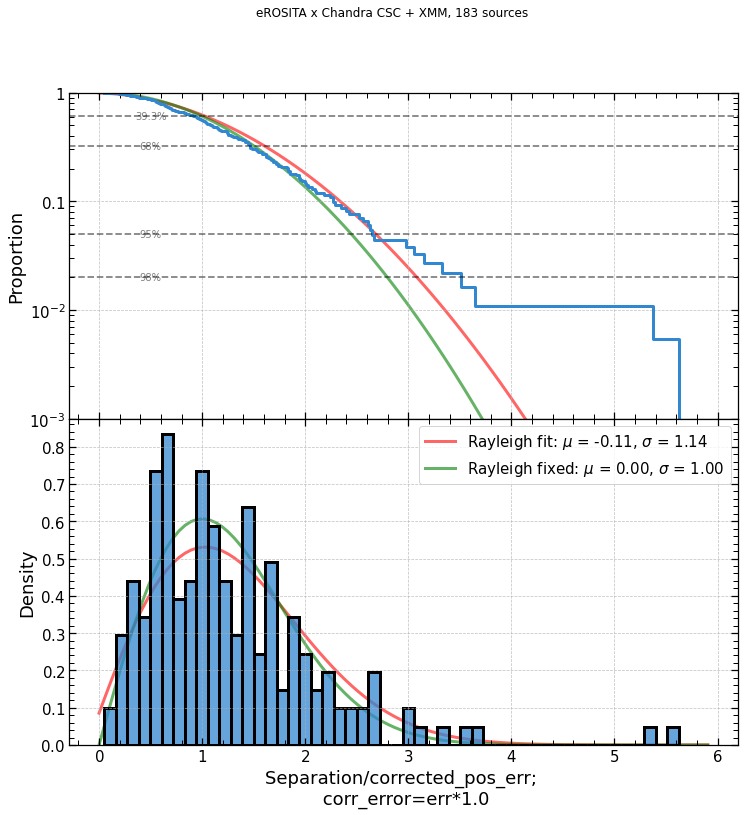

In [38]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='x_ray_sep', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')



<AxesSubplot:xlabel='x_ray_ero_flux_rat', ylabel='Count'>

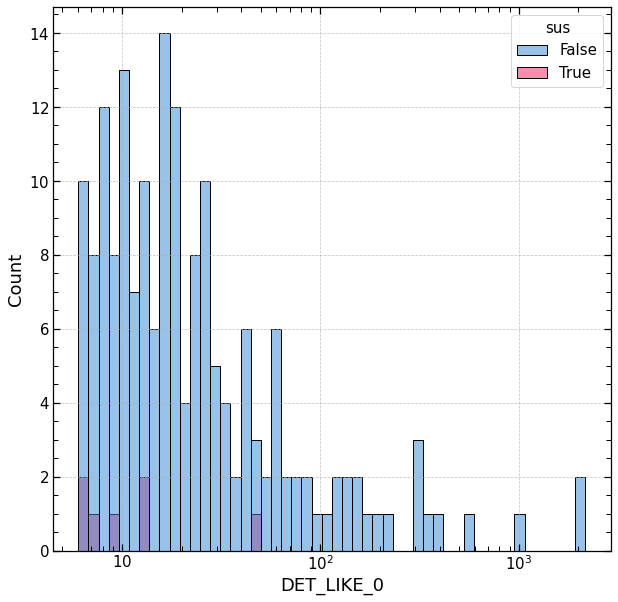

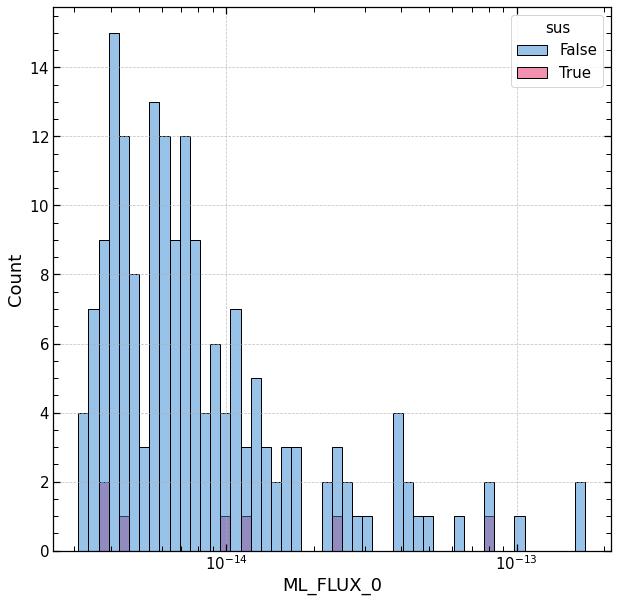

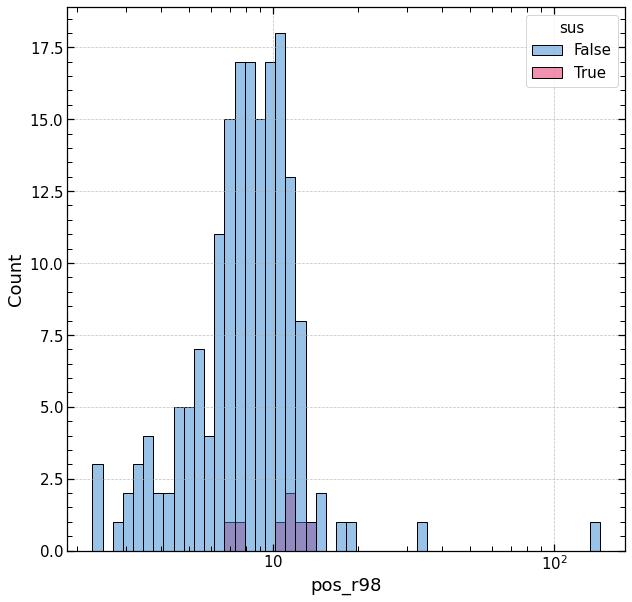

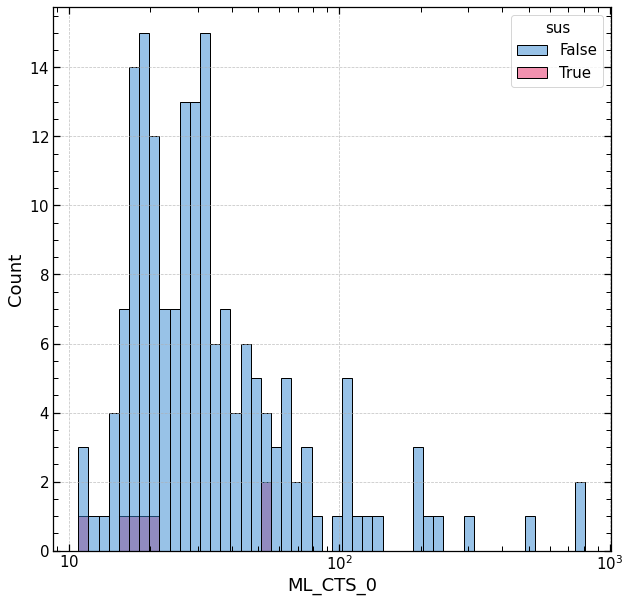

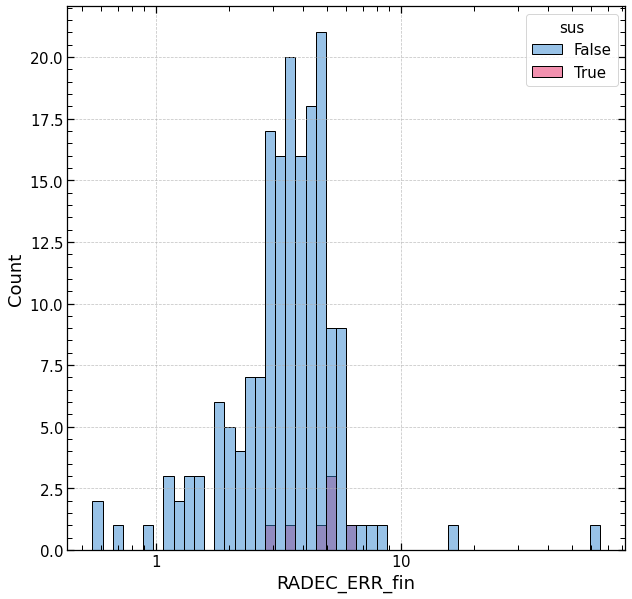

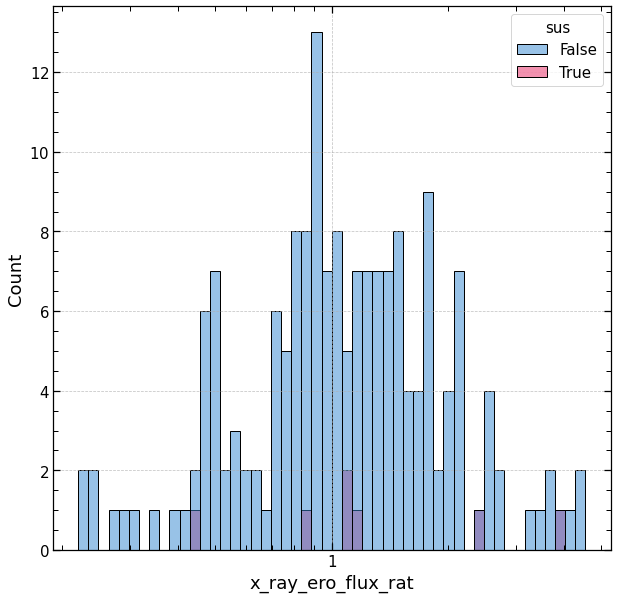

In [39]:
plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'DET_LIKE_0', hue = 'sus', log_scale=True, bins = 50)


plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'ML_FLUX_0', hue = 'sus', log_scale=True, bins = 50)


plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'pos_r98', hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'ML_CTS_0', hue = 'sus', log_scale=True, bins = 50)

plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'RADEC_ERR_fin', hue = 'sus', log_scale=True, bins = 50)


plt.figure(figsize=(10,10))
sns.histplot(data = final_ctps, x = 'x_ray_ero_flux_rat', hue = 'sus', log_scale=True, bins = 50)